---
title: |
  Soundscapy: A python package for soundscape assessment and analysis
authors: 
  - name: Andrew Mitchell
    email: "andrew.mitchell.18@`ucl.ac.uk`{=typst}"
    affiliations: 
      - name: University College London
        department: Institute for Environmental Design & Engineering, The Bartlett
        address: London, UK
abstract: |
  Soundscape questionnaires are widely used to gather subjective information about people's perceptions and attitudes towards their acoustic environment. Despite the widespread adoption of ISO/TS 12913-3 guidelines for analyzing soundscape survey data, there are still several interpretations and challenges in application of the standard. To enable the easy, accessible, and consistent analysis of soundscape data, an open-source python package called Soundscapy has been developed. This package implements a visualization approach for soundscape data analysis using a probabilistic method that depicts the collective perception of a soundscape as a distribution of responses within the circumplex. In addition, functions for psychoacoustic and acoustic analysis of binaural data are included, with a focus on consistent and optimized processing of multiple recordings. This conference paper outlines the important features of Soundscapy, explains its basic functioning, lists its current capabilities, and gives recommendations for its best use. Finally, the future development of Soundscapy is proposed, including the integration of predictive soundscape models for use in automated assessment and design.
format:
  internoise-typst: 
    keep-typ: true
  # internoise-pdf: default
bib-typst: FellowshipRefs-biblatex.bib
# bibliography: FellowshipRefs-biblatex.bib
execute:
  cache: true
  keep-ipynb: true
code-line-numbers: true
---

In [2]:
#| include: false
import matplotlib.pyplot as plt
from pathlib import Path
import time
import pandas as pd
from soundscapy.analysis.parallel_processing import parallel_process
import warnings
warnings.filterwarnings("ignore")

__spec__ = None # solves an bug with multiprocessing

wav_dir = Path("data")

# Introduction

Since 2018, the ISO 12913 series of standards has provided a framework for the measurement, analysis, and reporting of soundscape perception @ISO12913Part2 @ISO12913Part3. The standard outlines a structured approach to soundscape data collection, including the use of questionnaires, binaural recordings, and environmental measurements. While other software tools exist for conducting soundscape analysis (see @sec-psychoacoustic for some examples), these are typically targeted towards audio analysis in the vein of soundscape ecology, rather than the analysis of soundscape perception data. Soundscapy aims to enable the analysis of human perceptual data from soundscapes, following the definition of 'soundscape' given in ISO 12913-1 @ISO12913Part1. 

In addition to implementing analysis methods for questionnaire data, Soundscapy also provides tools for the analysis of binaural recordings in line with ISO 12913-3. This includes the calculation of acoustic indices, such as the sound pressure level (SPL) and psychoacoustic indices, such as the loudness level (N) and sharpness (S). This paper will provide an overview of these features as implemented in the current version (v0.6), how these improve over existing tools, and a discussion of the future development of Soundscapy.

# Background

In 2010, Axelsson, Nilsson, & Berglund @Axelsson2010principal proposed a *principal components* model of soundscape perception. Due to its similarity to the the widely-studied Russell's circumplex model of affect @Russell1980circumplex, Axelsson's principal component model is often referred to as the Soundscape Circumplex Model in soundscape literature. The circumplex model and the Swedish Soundscape Quality Protocol (SSQP) @Axelsson2012Swedish utilizing it quickly became the predominant method of soundscape assessment in both scientific literature and professional practice @Aletta2023Adoption, due to its ease of use, interpretability, and, crucially, its ability to summarise the complex interrelationships between soundscape descriptors within a straightforward and familiar two-dimensional space. Together with a similar principal component model in Cain et al. @Cain2013development, the framework of the circumplex model of soundscape perception was subsequently adapted into an integral part of the standardised data collection, specifically in Method A of ISO/TS 12913-2 @ISO12913Part2.

The soundscape circumplex model is composed of eight scales, which are arranged in two bipolar dimensions, with pleasant-annoying along the *x* axis (valence) and eventful-uneventful along the *y* axis (arousal)<!--, as shown in @fig-circumplex-->. These scales can be projected into the two dimensional circumplex space using the following equations @Mitchell2023Testing:

$$
P_{ISO} = \frac{1}{\lambda_{Pl}} \sum_{i=1}^{8} \cos{\theta_i} \cdot \sigma_i
$$ {#eq-isopl}

$$
E_{ISO} = \frac{1}{\lambda_{Pl}} \sum_{i=1}^{8} \sin{\theta_i} \cdot \sigma_i
$$ {#eq-isoev}

where *i* indexes each circumplex scale, $\theta_i$ gives the angle for the circumplex scale, and $\sigma_i$ is the value for that scale. The $1 / \lambda$ provides a scaling factor to bring the range of $P_{ISO}$, $E_{ISO}$ values to $[-1, +1]$:

$$
\lambda_{Pl} = \frac{\rho}{2} \sum_{i=1}^{8} |\cos{\theta_i}|
$$ {#eq-lampl}

$$
\lambda_{Ev} = \frac{\rho}{2} \sum_{i=1}^{8} |\sin{\theta_i}|
$$ {#eq-lamev}

where $\rho$ is the range of the possible response values (i.e. $\rho = 5-1 = 4$ for the Likert responses used in ISO/TS 12913-3).

Currently, the soundscape community relies heavily on the framework proposed in ISO/TS 12913-2, both for theory development and for procuring empirical evidence of the benefits of the soundscape approach in real life scenarios. In a recent literature review, Aletta & Torresin @Aletta2023Adoption identified 254 scientific publications which have referred to ISO 12913 since its publication in 2018, with 50 of them appropriately making use of the data collection methods. Of those, several papers included multiple studies, with 51 studies making use of the circumplex model as recommended in the ISO standard. In addition, the circumplex model has been used in many more studies without reference to the ISO standard @Engel2018Review.

However, there is currently no standardised software enabling the circumplex analysis recommended by the ISO 12913 standards. This can lead to inconsistencies, errors, and delays in the application of the recommendations. With the revision of ISO 12913 Part 3 currently underway and proposals for more advanced analysis methods being discussed, an easy-to-use and free tool is even more necessary to ensure the consistent and validated application of the standard.

In addition to the recommendations for the analysis of this questionnaire data, the ISO/TS 12913 series of standards also provides a framework for the analysis of binaural recordings in ISO/TS 12913-3. This includes the calculation of acoustic indicators, such as the sound pressure level (SPL) and psychoacoustic metrics, such as the loudness level (N) and sharpness (S). These indicators 'enable the characterization of the acoustic environment [...], the quantification of the acoustical impact on the listener, and the exploration of relationships between physical properties of the environments and human response behaviour' [@ISO12913Part3]. 

Several software tools exist for psychoacoustic analysis, the most notable of which is the ArtemiS suite from HEAD Acoustics @HEADGmBH2024ArtemiS. These commercial software packages are widely used in the industry for the analysis of sound and vibration data. However, these tools are often prohibitively expensive for many purposes and are not specifically designed for the analysis of large scale soundscape data. The recent development of the MoSQITo sound quality library @Coop2024MOSQITO has provided a free open-source python alternative for single-channel psychoacoustic analysis. Soundscapy builds upon MoSQITo, to implement the psychoacoustic analysis methods recommended in ISO/TS 12913-3 for binaural recordings.

# History and description

Soundscapy was initially developed for working with data collected as part of the Soundscape Indices (SSID) project @Kang2019Towards. A method for *in situ* data collection was developed, named the SSID Protocol, which enabled simultaneous collection of binaural recordings, survey questionnaires, and environmental data @Mitchell2020Soundscape. The SSID Protocol was designed to be compatible with the ISO/TS 12913 standards, optimized for large scale data collection. The data collected under this protocol forms the open-access International Soundscape Database (ISD) @Mitchell2024International, which is described further in @sec-databases.

Building upon this database, a new method for analysing soundscape circumplex data was developed by Mitchell, Aletta, & Kang @Mitchell2022How. This method uses a distribution-based approach to model the distribution of responses to soundscape questionnaires within the circumplex (see @fig-plots). In this method, each response is transformed according to @eq-isopl and @eq-isoev, and the distribution of these responses in the circumplex is visualized using a kernel density estimation. In this way, the collective perception of a group or of a location can be thought of as the bivariate distribution of responses within the circumplex. Soundscapy was initially developed as the research code to explore and develop this method in @Mitchell2022How before being published as an open-source package in 2022.

<!-- To support this work, international standards like @ISO12913Part3 have been developed to provide a framework for the measurement, analysis, and reporting of soundscape perception. Soundscapy is a new open-source Python package that aligns with the requirements outlined in this standard, aiming to make advanced soundscape analysis techniques accessible to a wide audience. By basing its core functionality on ISO 12913-3, Soundscapy aims to lower the barriers to entry and enable more people to conduct high-quality soundscape research. -->


# Features

Soundscapy is an open package of Python functions. This means there is not a user interface and it is necessary to install and write Python code. The functions are designed to be simple to use even with limited experience writing code. 

## Databases {#sec-databases}

Soundscapy was primarily developed to work with the International Soundscape Database (ISD)^[The ISD is available from Zenodo [https://zenodo.org/records/10672568](https://zenodo.org/records/10672568).] @Mitchell2024International, which will be described here and used for the examples in this paper. The ISD is a large database of soundscape recordings and survey data collected according to the SSID Protocol @Mitchell2020Soundscape. The database contains 2,706 recordings, paired with 3,590 survey responses, collected in 6 cities across Europe and China.

The ISD contains three primary types of data - surveys, pre-calculated psychoacoustic metrics, and binaural audio recordings. The surveys include several blocks of questions, the most important of which are the Perceptual Attribute Questions (PAQs). These form the 8 descriptors of the soundscape circumplex @Axelsson2010principal - pleasant, vibrant, eventful, chaotic, annoying, monotonous, uneventful, and calm. In addition, each survey includes other information about the soundscape and demographic characteristics (age, gender, etc.). Finally, the survey section includes identifiers of when and where the survey was conducted - the `LocationID`, `SessionID`, `latitude`, `longitude`, `start_time`, etc.

The ISD is included with Soundscapy and can be loaded with the following code:

In [3]:
#| echo: true
#| output: false
import soundscapy as sspy
df = sspy.isd.load()

The final bit of information for the survey is the `GroupID`. When stopping respondents in the survey space, they were often stopped as a group, for instance a couple walking through the space would be approached together and given the same `GroupID`. While each group completes the survey, a binaural audio recording is taken, typically lasting about 30 seconds. Therefore, each `GroupID` can be connected to around 1 to 10 surveys, and to one recording.

In addition to the ISD, Soundscapy includes a module for working with the Soundscape Attributes Translation Project (SATP) dataset^[The SATP dataset is available from Zenodo [https://zenodo.org/records/10159673](https://zenodo.org/records/10159673).] a project to provide validated translations of soundscape attributes in languages other than English. The SATP includes 19,089 survey responses, including 708 participants, in 19 languages. It can be loaded within soundscapy using `sspy.datasets.satp.load_zenodo()`. In addition, work is currently underway to implement a module for working with the Affective Responses to Augmented Urban Soundscapes (ARAUS) dataset @Ooi2023ARAUS. 

## Working with soundscape questionnaire data

All data in Soundscapy is handled using the `pandas` library @pandas. Soundscapy implements some built in functions for working with both the ISD specifically and with soundscape data more generally. One example of an ISD specific function is `isd.validate()` which implements a series of data quality checks on the questionnaire data @Erfanian2021Psychological and returns a validated dataset `df` and a set of the excluded data `excl_df`. `add_iso_coords()` implements the extended versions of the ISO 12913-3 method for calculating the coordinates within the circumplex from the perceptual attributes, given in @eq-isopl and @eq-isoev, and adding them to the dataframe under the keys `ISOPleasant` and `ISOEventful`.

In [4]:
#| output: false
df, excl_df = sspy.isd.validate(df)
df = sspy.surveys.add_iso_coords(df)

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]


Soundscapy expects the PAQ values to be Likert scale values ranging from 1 to 5 by default, as specified in ISO/TS 12913-2 and the SSID Protocol. However, it is possible to use data which, although structured the same way, has a different range of values. For instance, this could be a 7-point Likert scale, or a 0 to 100 scale. By passing these numbers to the `add_iso_coords()` function as `val_range=(0, 100)`, Soundscapy will automatically scale the ISOCoordinates from -1 to +1 according to @eq-lampl and @eq-lamev.

## Visualizing soundscape data

Once the data is loaded, it can be filtered as needed and visualise the distribution of responses within the soundscape circumplex. The plotting functions make use of the `seaborn kdeplot()` function @Waskom2021seaborn, adding additional customizations and features. 

::: {#fig-plots fig-cap="Demonstration of full (left) and simplified (right) soundscape distribution plots"}

<Axes: title={'center': 'Comparison between two soundscapes'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

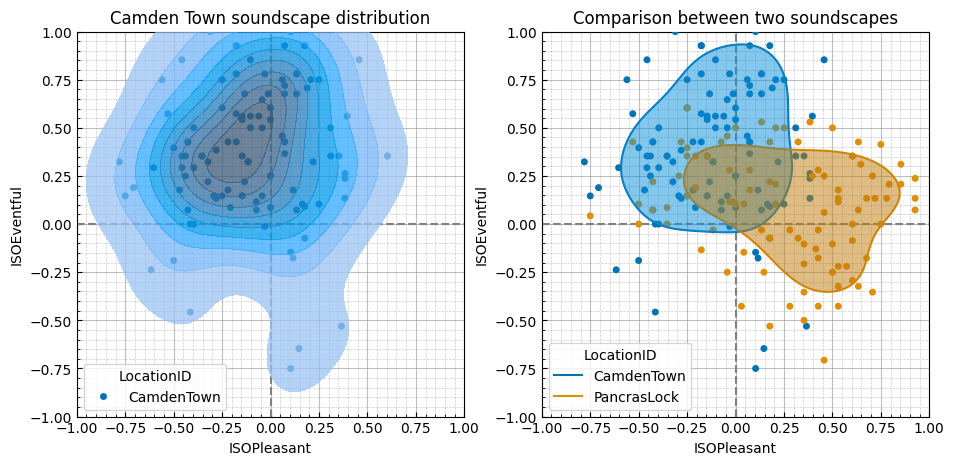

In [15]:
#| layout: [100]
# Setup side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
# Plot the full soundscape distribution
sspy.plotting.density(
  sspy.isd.select_location_ids(df, "CamdenTown"),
  title= "Camden Town soundscape distribution",
  hue="LocationID",
  ax=axes[0],
)
# Plot the simplified soundscape distributions, using the hue variable
sspy.plotting.density(
  sspy.isd.select_location_ids(df, ("CamdenTown", "PancrasLock")),
  title="Comparison between two soundscapes",
  figsize=(5, 5),
  hue="LocationID",
  density_type='simple',
  ax=axes[1],
)

:::

This distribution-based visualisation and analysis clearly shows three important characteristics of the soundscape perception of a group or location:

1. The distribution across both pleasantness and eventfulness, including the central tendency, the dispersion, and any skewness in the response.
2. The general shape of the soundscape within the circumplex space - in this case, Pancras Lock is mostly in the pleasant half, with a slight skew towards eventfulness.
3. The degree of agreement about the soundscape perception among the sample.

In addition to these visualisations, Soundscapy provides functions for calculating some basic statistics about the distribution of responses, such as the mean, median, and standard deviation, as well as metrics inspired by reporting from noise annoyance studies, such as the percentage of respondents who rated the soundscape as 'pleasant' or 'eventful'.

## Psychoacoustic, Acoustic, and Bioacoustic Analysis {#sec-psychoacoustic}

To implement the binaural recording processing, Soundscapy relies on three packages:

- Python Acoustics (`acoustics`): Python Acoustics is a library aimed at acousticians. It provides two benefits - first, the analysis functions are referenced directly to the relevant standard. Second, Soundscapy subclasses the `Signal` class to provide the binaural functionality, and any function available within the `Signal` class is also available to Soundscapy's `Binaural` class. 
- scikit-maad @Ulloa2021scikit (`maad`): scikit-maad is a modular toolbox for quantitative soundscape analysis, focused on ecological soundscapes and bioacoustic indices. scikit-maad provides a huge suite of ecosoundscape focused indices, including Acoustic Richness Index, Acoustic Complexity Index, Normalized Difference Soundscape Index, and more.
- MoSQITo (`mosqito`): MoSQITo is a modular framework of key sound quality metrics, providing the psychoacoustic metrics for Soundscapy.

In [29]:
#| include: false
#| output: false
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

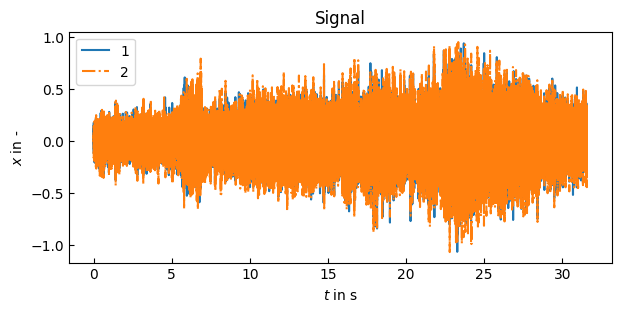

In [42]:
#| label: fig-binaural
#| fig-cap: Loading and viewing a binaural recording in Soundscapy.
from soundscapy import Binaural

# Load the binaural recording from a local wav
b = Binaural.from_wav(wav_dir.joinpath("CT101.wav"))
# Plot the binaural recording
ax = b.plot() 

# Resizing for the paper
ax.figure.set_size_inches(7, 3)

The metrics currently available are:

- Python Acoustics: $L_{Zeq}$, $L_{Aeq}$, $L_{Ceq}$, SEL, and all associated statistics ($L_5$ through $L_{95}$, $L_{max}$ and $L_{min}$, as well as kurtosis @Qiu2020Kurtosis and skewness).
- scikit-maad: So far, only the combined `all_temporal_alpha_indices` and `all_spectral_alpha_indices` functions from `scikit-maad` have been implemented; calculating them individually is not yet supported. `all_temporal_alpha_indices` comprises 16 temporal domain acoustic indices, such as temporal signal-to-noise ratio, temporal entropy, and temporal events. `all_spectra_alpha_indices` comprises 19 spectral domain acoustic indices, such as the Bioacoustic Index, Acoustic Diversity Index, NDSI, Acoustic Evenness Index, and Acoustic Complexity Index.
- MoSQITo: Zwicker time-varying Loudness ($N$) @ISO2017Acoustics and Roughness ($R$) @Daniel1997Psychoacoustical are implemented directly. In addition, Sharpness ($S$) can be calculated directly or from the the loudness parameters.

Soundscapy combines all of these metrics and makes it easy to compute any or all of them in a reproducible way for a binaural audio recording. These results have been preliminarily validated through comparison of results obtained from Head Acoustics ArtemiS suite on a set of real-world recordings.

<!-- ```#show table.cell.where(x: 0): set text(style: "italic");```{=typst}
```#show table.cell.where(y: 0): set text(style: "normal", weight: "bold");```{=typst}
```#set table(stroke: (_, y) => if y > 0 { (top: 0.8pt) });```{=typst} -->

In [110]:
#| output: false
#| include: false
b = Binaural(b.resample(48000), fs=48000)

In [111]:
#| label: tbl-psycho
#| tbl-cap: Direct output of psychoacoustic metrics calculated by Soundscapy for a single binaural recording.
metric = "loudness_zwtv"
stats = (5, 50, 'avg', 'max')
func_args = {'field_type': 'free'}
b.mosqito_metric(metric, statistics=stats, verbose=False, func_args=func_args)

N_5       N_50      N_avg      N_max
Recording Channel                                            
Rec       Left     45.126243  36.826403  35.434689  47.617004
          Right    47.388868  38.385263  37.061130  49.509641

### Consistent Analysis Settings

A primary goal when developing this library was to make it easy to save and document the settings used for all analyses. This is done through a `settings.yaml` file and the `AnalysisSettings` class. Although the settings for each metric can be set at runtime, the `settings.yaml` file allows you to set all of the settings at once and document exactly what settings were passed to each analysis function and to share these settings with collaborators or reviewers.

These settings can then be passed to any of the analysis functions, rather than separately defining your settings as we did above. This is particularly useful when performing batch processing on an entire folder of wav recordings. Soundscapy provides a set of default settings which can be easily loaded in:

In [112]:
analysis_settings = sspy.AnalysisSettings.default()

and the settings file for e.g. the Loudness calculation can be printed:


In [113]:
analysis_settings['MoSQITo']['loudness_zwtv']

{'run': False,
 'main': 5,
 'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
 'channel': ['Left', 'Right'],
 'label': 'N',
 'parallel': True,
 'func_args': {'field_type': 'free'}}

These settings can then be passed to any of the analysis functions, like the following function which will calculate all of the metrics requested in the settings file:


In [114]:
res_df = b.process_all_metrics(analysis_settings, verbose=False)

### Batch Processing

The other primary goal was to make it simple and fast to perform this analysis on many recordings. One aspect of this is unifying the outputs from the underlying libraries and presenting them in an easy to parse format. The analysis functions from Soundscapy can return a MultiIndex pandas DataFrame with the Recording filename and Left and Right channels in the index and a column for each metric calculated, as shown in @tbl-psycho. This dataframe can then be easily saved to a .csv or Excel spreadsheet. Alternatively, a dictionary can be returned for further processing within Python. The key point is that after calculating 100+ metrics for 1,000+ recordings, the user will be left with a single tidy spreadsheet.

When processing many files, the MoSQITo functions in particular can be quite slow, so running each recording one at a time can be prohibitively slow and only utilize a small portion of the available computing power. To help with this, a set of simple functions is provided to enable parallel processing, such that multiple recordings can be processed simultaneously by a multi-core CPU. To demonstrate the performance improvement, we can process a set of 20 test recordings in series and in parallel:

In [115]:
#| include: false
#| echo: false
from soundscapy.analysis.binaural import prep_multiindex_df, add_results
import json
levels = wav_dir.joinpath("Levels.json")
with open(levels) as f:
  levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)

In [116]:
#| include: false
#| output: false
ser_start = time.perf_counter()

In [117]:
#| label: serial-process
#| output: false
for wav in wav_dir.glob("*.wav"):
  recording = wav.stem
  decibel = tuple(levels[recording].values())
  b = Binaural.from_wav(wav, calibrate_to=decibel)
  ser_df = add_results(
    df, b.process_all_metrics(analysis_settings, verbose=False)
    )

[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow ca

In [118]:
#| output: false
#| include: false
ser_end = time.perf_counter()

In [119]:
#| include: false
#| output: false
par_start = time.perf_counter()

In [120]:
#| output: false
#| label: parallel-process
#| fig-cap: Batch processing of 10 recordings using Soundscapy's parallel processing function.
par_df = parallel_process(
  wav_dir.glob("*.wav"), df, levels, analysis_settings, verbose=False)

Processing files:   0%|          | 0/20 [00:00<?, ?it/s]

Processing CT103
Processing RS101
Processing CT107
Processing RS108
Processing CT108
Processing CT109
Processing RS102
Processing CT102
Processing CT101
Processing RS109
Processing RS103
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs should be >=48 kHz.
[Warning] Signal resampled to 48 kHz to allow calculation. To fulfill the standard requirements fs 

In [121]:
#| output: false
#| include: false
par_end = time.perf_counter()

In [122]:
#| echo: false
#| output: asis
# print(f"Time taken for serial processing: {(ser_end - ser_start)/60:.2f} min")
# print(f"Time taken for parallel processing: {(par_end - par_start)/60:.2f} min")
# print(f"Speedup: {(ser_end - ser_start)/(par_end - par_start):.2f} times.")
from IPython.display import Markdown
ser_time = (ser_end - ser_start)
par_time = (par_end - par_start)
Markdown(f"Tested on a Macbook Pro M2 Max, processing 20 recordings (total of 10 minutes, 41 seconds of audio) in series took {ser_time/60:.1f} minutes, while processing the same 20 recordings in parallel took {par_time/60:.1f} minutes, a speed up of {ser_time / par_time:.1f} times.")


Tested on a Macbook Pro M2 Max, processing 20 recordings (total of 10 minutes, 41 seconds of audio) in series took 29.4 minutes, while processing the same 20 recordings in parallel took 7.7 minutes, a speed up of 3.8 times.


# Future development and Conclusions

In addition to continuing to improve the core functionality of Soundscapy, there are several areas where future development will be focused. As of v0.6, Soundscapy is primarily focused on implementing the analysis called for in ISO/TS 12913-3. Primarily, we aim to integrate new and existing predictive soundscape models, which will allow us to predict the soundscape quality of a location based on its acoustic characteristics @Mitchell2023conceptual. The goal is to develop Soundscapy into a robust modelling and prediction pipeline, which allows for the estimation of soundscape perception based on quantifiable or estimable factors (see @fig-future). 

![Future development plans for Soundscapy](Soundscapy2.png){#fig-future width=100%}

The core of this development will be the creation and/or integration of machine learning models based on acoustic features, such as sound levels, frequency content, and temporal patterns. Ideally, the Soundscapy pipeline will comprise three modules: 1) input analysis (psychoacoustic analysis and data cleaning); 2) the predictive model; 3) output visualisation. As opposed to simply providing a single trained model, the goal is to create a modular system that allows for the integration of new models and the comparison of different models.

The successful implementation of these models can address several challenges which the soundscape approach faces in practical applications. The first of these challenges is predicting how a change in an existing sound environment will be reflected in the soundscape perception. This is closely related to the idea of soundscape interventions, where a particular design change is implemented, aimed at preserving or enhancing the existing soundscape @Moshona2023Deriving. Predicting how a particular intervention would improve the soundscape is not yet possible with the retrospective methods available. The second challenge is the prediction of soundscape perception in new locations, where no survey data is available. This is particularly important for urban planning and design, where the soundscape is a key consideration in the design process @Mitchell2023conceptual.

The current state of Soundsapy makes it straightforward to analyse soundscape data according to the ISO/TS 12913-3 standard, and to process binaural recordings according to the same standard, in a reproducible and open way. The future development of Soundscapy can help enable innovative approaches to both soundscape research and practice, by providing a consistent and validated method for the prediction of soundscape perception. More information, including in depth tutorials and a development roadmap, can be found in the Soundscapy documentation at [https://soundscapy.readthedocs.io/en/latest/](https://soundscapy.readthedocs.io/en/latest/).

# Acknowledgements {.unnumbered}
This work was supported by funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation programme (Grant Agreement No. 740696, project title: Soundscape Indices - SSID). 

# Code Availability {.unnumbered}

The Soundscapy package is available on PyPI and can be installed using `pip install soundscapy`. The source code is available on GitHub at [https://github.com/MitchellAcoustics/Soundscapy](https://github.com/MitchellAcoustics/Soundscapy), where contributions are welcomed!